In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from truckscenes import TruckScenesDataset

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from hovsg.dataloader.generic import RGBDDataset
import numpy as np
import open3d as o3d
import cv2

class TruckScenesDataset(RGBDDataset):
    """
    Dataset class for a LiDAR and multi-camera dataset.

    This class loads RGB images from multiple cameras and corresponding LiDAR point clouds,
    generates depth images by projecting points onto the image plane, and provides poses
    and intrinsics for each sample.
    """

    def __init__(self, cfg):
        """
        Args:
            cfg: Configuration dictionary containing:
                - root_dir: Path to the root directory containing the dataset.
                - transforms: Optional transformations to apply to the data.
        """
        super(TruckScenesDataset, self).__init__(cfg)
        self.root_dir = cfg["root_dir"]
        self.transforms = cfg["transforms"]
        # Depth scale set to 1.0 assuming LiDAR points are in meters
        self.scale = 1.0
        # Intrinsics will be loaded per sample, so initialize as None
        self.rgb_intrinsics = None
        self.depth_intrinsics = None
        self.data_list = self._get_data_list()

    def _get_data_list(self):
        """
        Generates a list of (scene, timestamp, camera) tuples representing all data samples.

        Returns:
            List of tuples (scene, timestamp, camera).
        """
        data_list = []
        trainval_dir = os.path.join(self.root_dir, "trainval")
        for scene in os.listdir(trainval_dir):
            scene_dir = os.path.join(trainval_dir, scene)
            if not os.path.isdir(scene_dir):
                continue
            # Get timestamps from labelled_points directory
            labelled_points_dir = os.path.join(scene_dir, "labelled_points")
            timestamps = [f.split(".")[0] for f in os.listdir(labelled_points_dir) if f.endswith(".pth")]
            timestamps = sorted(timestamps, key=int)
            # Get camera names from images directory
            images_dir = os.path.join(scene_dir, "images")
            cameras = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]
            for timestamp in timestamps:
                for camera in cameras:
                    data_list.append((scene, timestamp, camera))
        return data_list

    def __getitem__(self, idx):
        """
        Loads a data sample for the given index.

        Args:
            idx: Index of the data sample.

        Returns:
            Tuple of (rgb_image, depth_image, pose, rgb_intrinsics, depth_intrinsics).
        """
        scene, timestamp, camera = self.data_list[idx]

        # Load RGB image
        img_path = os.path.join(self.root_dir, "trainval", scene, "images", camera, f"{timestamp}.png")
        rgb_image = self._load_image(img_path)

        # Load LiDAR point cloud
        pcd_path = os.path.join(self.root_dir, "trainval", scene, "labelled_points", f"{timestamp}.pth")
        points_xyz, _, sem_labels, instance_labels = torch.load(pcd_path, weights_only=False)

        # Load camera pose (assumed to be camera-to-world transformation)
        pose_path = os.path.join(self.root_dir, "trainval", scene, "poses", camera, f"{timestamp}.txt")
        pose = self._load_pose(pose_path)

        # Load camera intrinsics
        intr_path = os.path.join(self.root_dir, "trainval", scene, "intrinsics", camera, f"{timestamp}.txt")
        intrinsics = self._load_rgb_intrinsics(intr_path)
        # Set both RGB and depth intrinsics to the same camera intrinsics
        rgb_intrinsics = intrinsics
        depth_intrinsics = intrinsics
        # Generate depth image by projecting LiDAR points
        depth_image, points_xyz_filtered = self._create_depth_image(points_xyz, pose, intrinsics, rgb_image.size)
        self.depth_intrinsics = depth_intrinsics
        # pcd_from_depth_image = self.create_pcd(rgb_image, depth_image, pose)
        # Apply transformations if provided
        if self.transforms is not None:
            rgb_image = self.transforms(rgb_image)
            depth_image = self.transforms(depth_image)
            
        return rgb_image, depth_image, pose, rgb_intrinsics, depth_intrinsics
        # return pcd_from_depth_image, points_xyz_filtered

    def _load_image(self, path):
        """
        Loads an RGB image from the given path.

        Args:
            path: Path to the RGB image file.

        Returns:
            RGB image as a PIL Image.
        """
        return Image.open(path)

    def _load_depth(self, path):
        """
        Not implemented as depth is generated from LiDAR points.

        Args:
            path: Placeholder argument.

        Raises:
            NotImplementedError: Depth images are generated, not loaded.
        """
        raise NotImplementedError("Depth images are generated from LiDAR points.")

    def _load_pose(self, path):
        """
        Loads the camera pose from the given path.

        Args:
            path: Path to the pose file.

        Returns:
            Camera pose as a 4x4 NumPy array.
        """
        return np.loadtxt(path)

    def _load_rgb_intrinsics(self, path):
        """
        Loads the camera intrinsics from the given path.

        Args:
            path: Path to the intrinsics file.

        Returns:
            Intrinsics as a 3x3 NumPy array.
        """
        return np.loadtxt(path)

    def _load_depth_intrinsics(self, path):
        """
        Not implemented separately as depth intrinsics match RGB intrinsics.

        Args:
            path: Placeholder argument.

        Raises:
            NotImplementedError: Uses same intrinsics as RGB.
        """
        raise NotImplementedError("Depth intrinsics are the same as RGB intrinsics.")
    
    def _create_depth_image(self, points_world, camera_to_world, intrinsics, image_size):
        """
        Creates a depth image by projecting LiDAR points onto the image plane, based on compute_mapping logic.

        Args:
            points_world: LiDAR points in world coordinates (N, 3).
            camera_to_world: Camera-to-world pose (4x4 matrix).
            intrinsics: Camera intrinsics (3x3 matrix).
            image_size: Tuple of (width, height) of the RGB image.

        Returns:
            Depth image as a PIL Image.
        """
        width, height = image_size
        cut_bound = 0

        # Add homogeneous coordinates to points
        points_hom = np.hstack((points_world[:, :3], np.ones((points_world.shape[0], 1))))

        # Transform points to camera coordinates
        world_to_camera = np.linalg.inv(camera_to_world)
        points_cam = (world_to_camera @ points_hom.T).T

        # Extract coordinates
        x = points_cam[:, 0]
        y = points_cam[:, 1]
        z = points_cam[:, 2]

        # Filter points in front of the camera
        mask = z > 0
        x = x[mask]
        y = y[mask]
        z = z[mask]
        points_world_filtered = points_world[mask]

        # Project to image plane
        fx, fy, cx, cy = intrinsics[0, 0], intrinsics[1, 1], intrinsics[0, 2], intrinsics[1, 2]
        u = (fx * x / z) + cx
        v = (fy * y / z) + cy

        # Round to integer pixel coordinates
        u = np.round(u).astype(int)
        v = np.round(v).astype(int)

        # Filter points within image boundaries with cut_bound
        in_image = (u >= cut_bound) & (u < width - cut_bound) & (v >= cut_bound) & (v < height - cut_bound)
        u = u[in_image]
        v = v[in_image]
        z = z[in_image]
        points_world_filtered = points_world_filtered[in_image]

        # Initialize depth image with infinity
        depth_image = np.full((height, width), np.inf, dtype=np.float32)

        # print("v,u shape", v.shape)
        # Assign minimum depth per pixel efficiently
        np.minimum.at(depth_image, (v, u), z)

        # Replace infinity with 0 for no-data pixels
        depth_image[depth_image == np.inf] = 0


        # Count occupied pixels (depth > 0)
        # print(image_size)
        occupied_pixels = np.sum(depth_image > 0)
        # print("occupied_pixels", occupied_pixels)
        # print("points_world_filtered", points_world_filtered.shape)
    
        # Convert to PIL Image
        return Image.fromarray(depth_image), points_world_filtered
    
    

    def create__pcd(self, rgb, depth, camera_pose=None):
        """
        Creates a point cloud from RGB and depth images with camera pose for LiDARCameraDataset.

        Args:
            rgb: RGB image as a PIL Image.
            depth: Depth image as a PIL Image.
            camera_pose: Camera pose as a 4x4 NumPy array (optional).

        Returns:
            Open3D point cloud.
        """
        # Use self.depth_intrinsics; assumes it's set elsewhere if not passed per sample
        if not hasattr(self, 'depth_intrinsics') or self.depth_intrinsics is None:
            raise ValueError("Depth intrinsics must be set in LiDARCameraDataset instance")

        # Convert RGB and depth images to NumPy arrays
        rgb = np.array(rgb).astype(np.uint8)
        depth = np.array(depth).astype(np.float32)

        # Resize RGB image to match depth image size if necessary
        if rgb.shape[0] != depth.shape[0] or rgb.shape[1] != depth.shape[1]:
            rgb = cv2.resize(rgb, (depth.shape[1], depth.shape[0]), interpolation=cv2.INTER_AREA)

        H, W = depth.shape
        camera_matrix = self.depth_intrinsics
        scale = self.scale  # Typically 1.0 for LiDARCameraDataset

        # Create meshgrid for pixel coordinates
        y, x = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
        depth = depth / scale

        # Mask for valid depth values
        mask = depth > 0
        x = x[mask]
        y = y[mask]
        depth = depth[mask]

        # Compute 3D points in camera coordinates
        X = (x - camera_matrix[0, 2]) * depth / camera_matrix[0, 0]
        Y = (y - camera_matrix[1, 2]) * depth / camera_matrix[1, 1]
        Z = depth

        # Create point cloud
        points = np.stack((X, Y, Z), axis=1)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        # Assign colors from RGB image
        colors = rgb[mask]
        pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)

        # Apply camera pose transformation if provided
        if camera_pose is not None:
            pcd.transform(camera_pose)

        return pcd

In [10]:
cfg = {"root_dir": "/shared/data/truckScenes/truckscenes_converted", "transforms": None}

dataset = TruckScenesDataset(cfg)

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 85.01490020751953


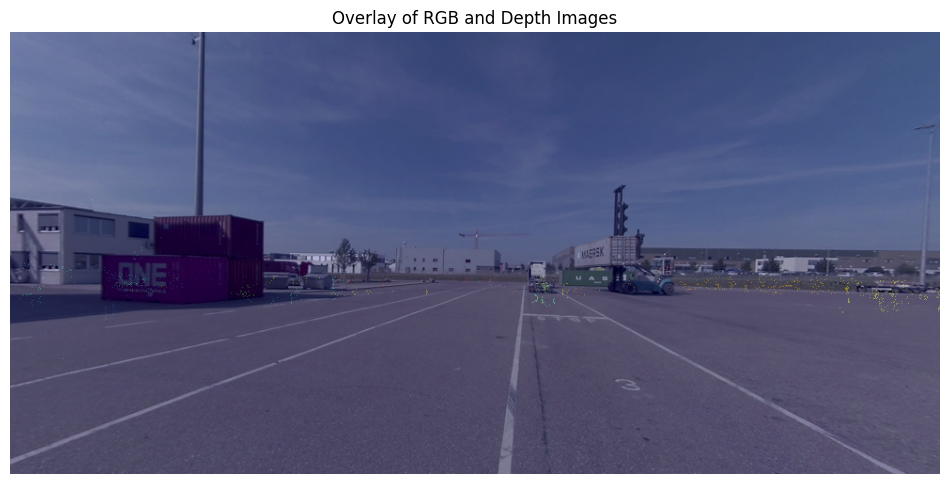

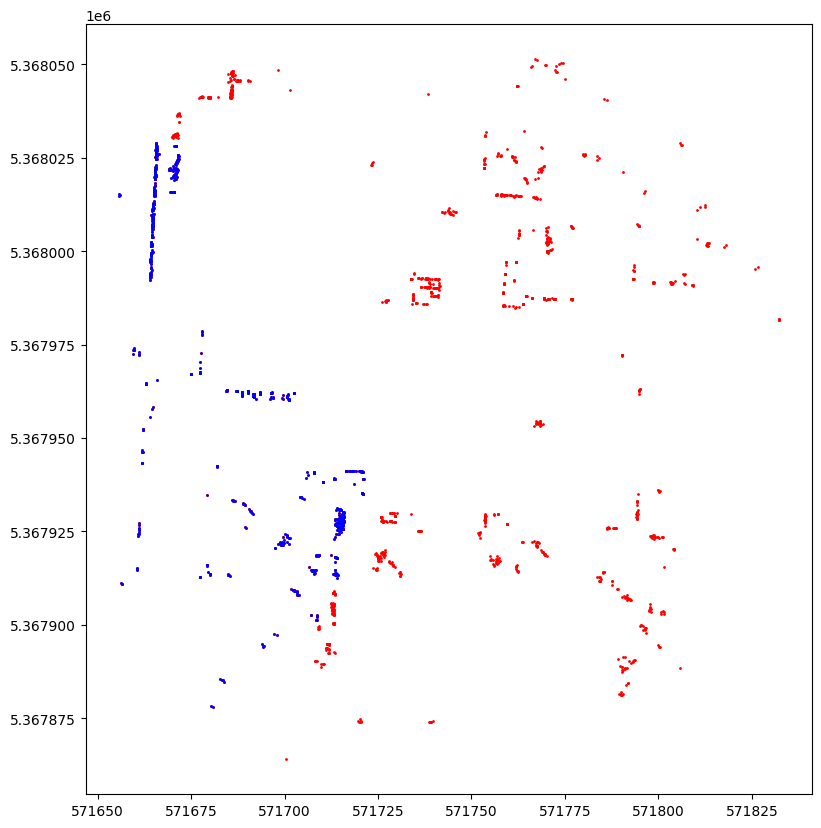

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 98.34557342529297


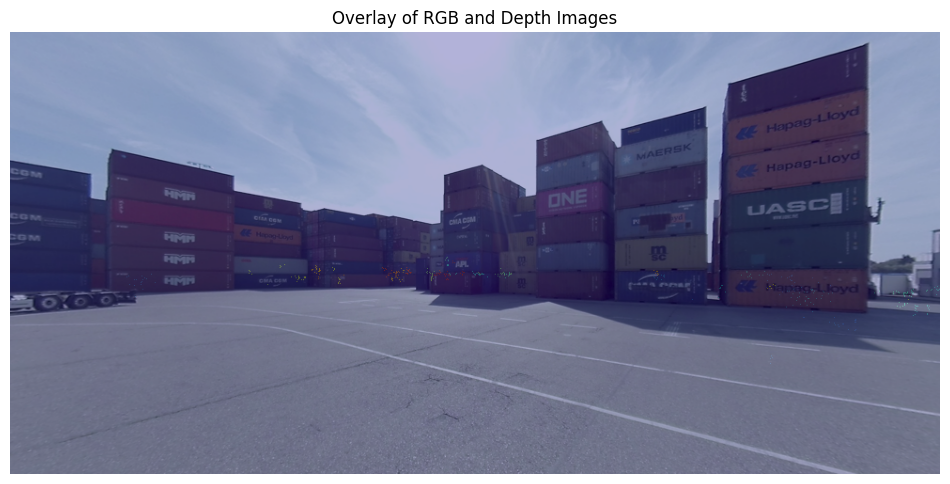

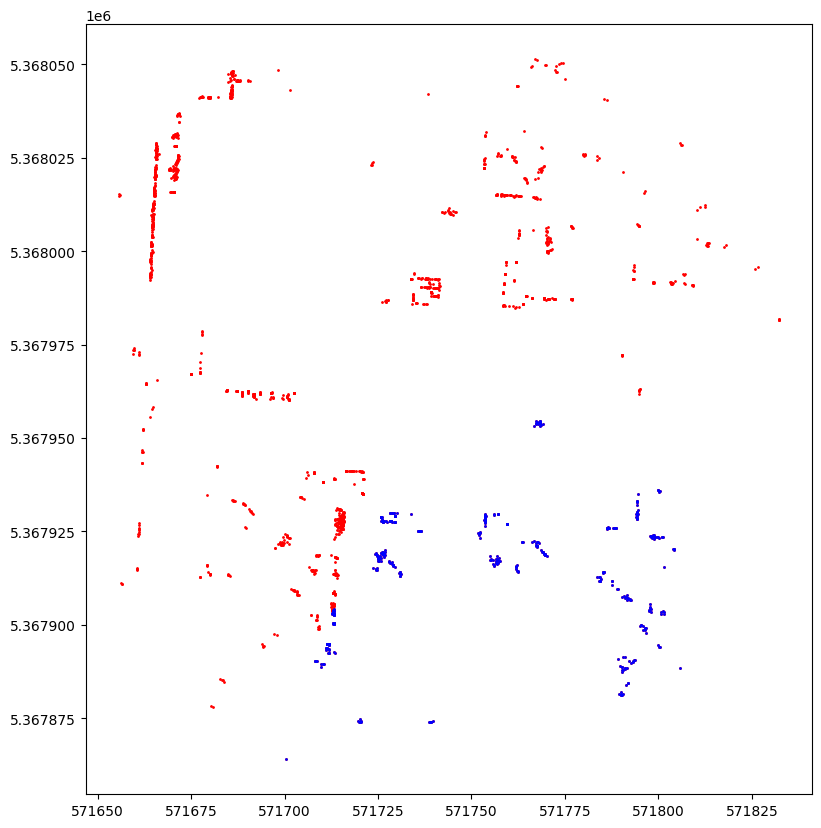

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 97.81690216064453


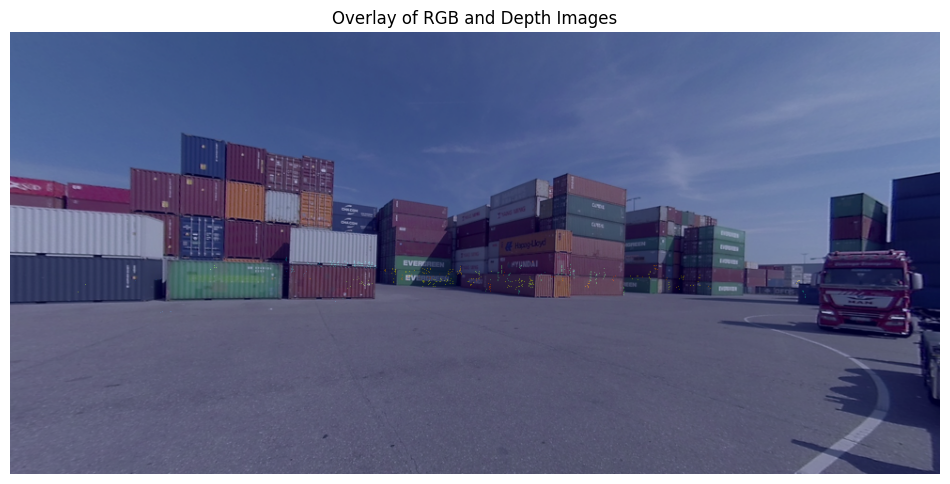

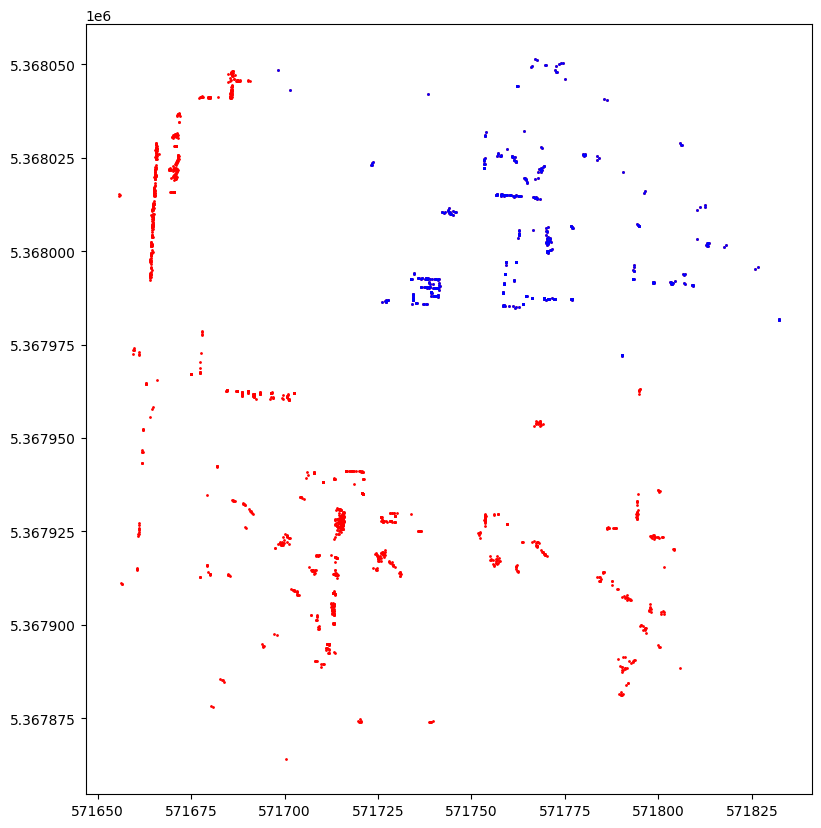

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 82.66798400878906


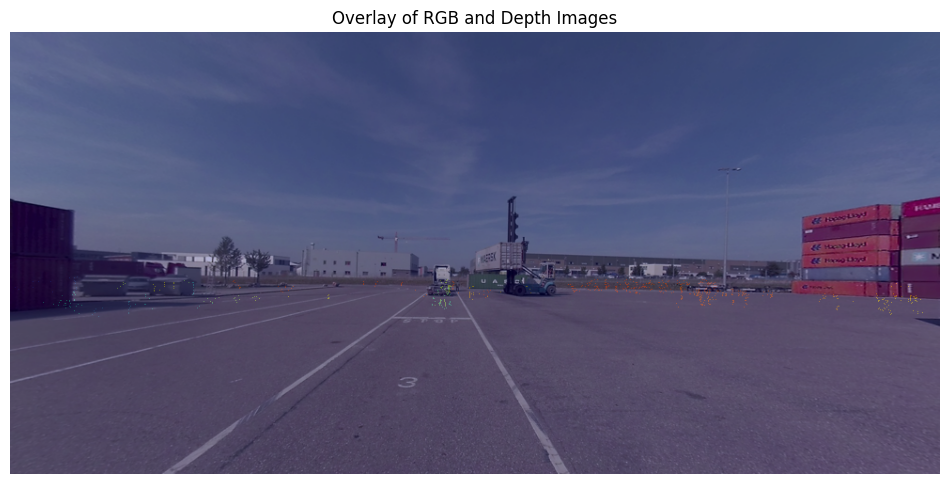

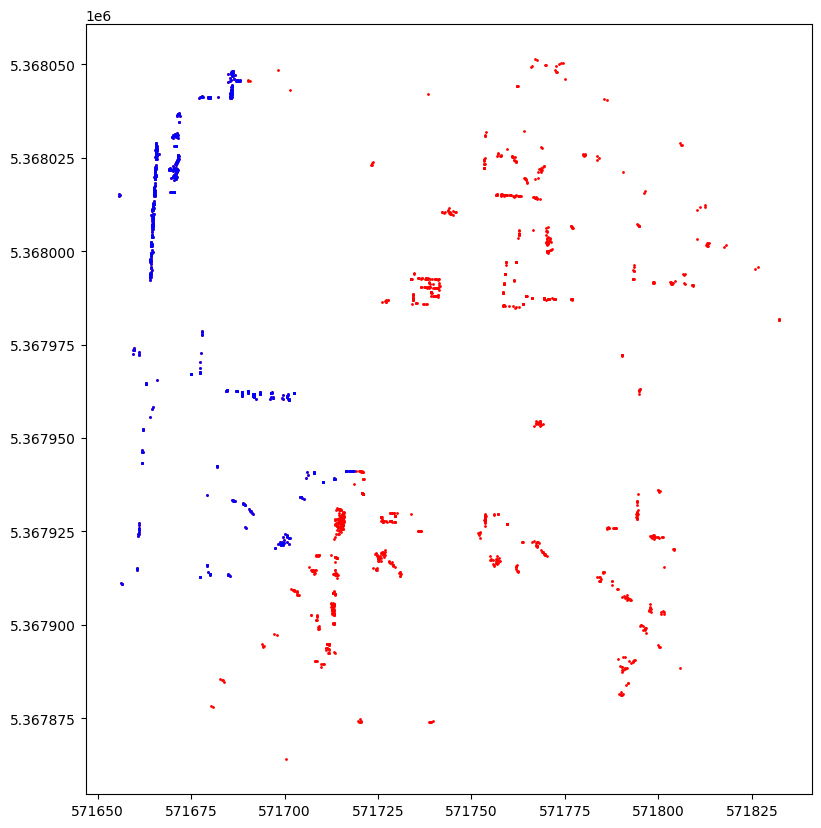

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 83.7876205444336


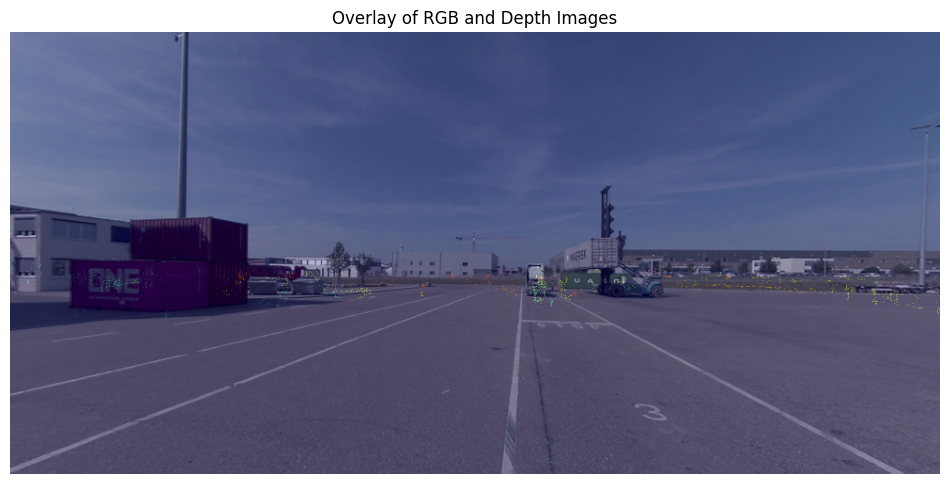

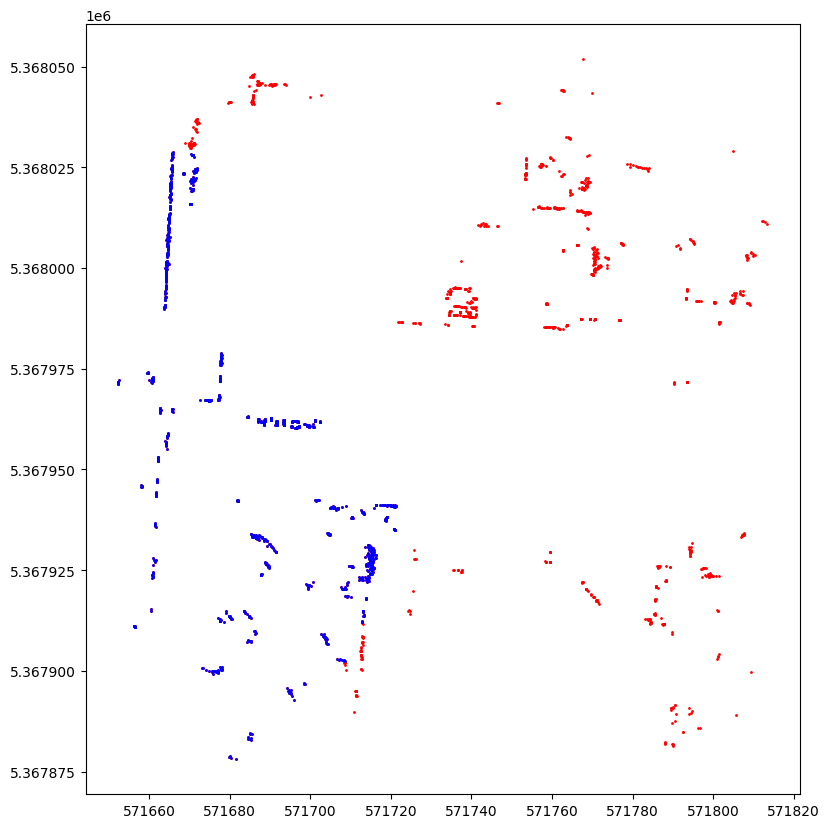

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 98.02523040771484


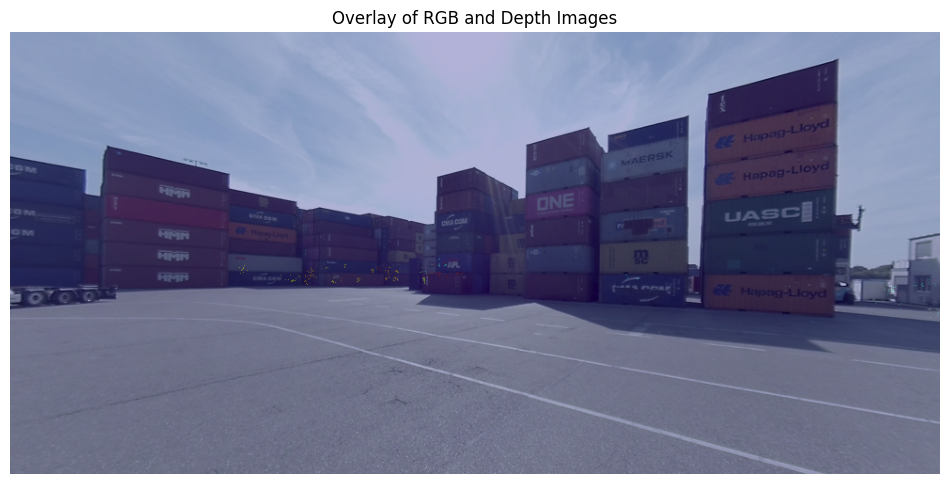

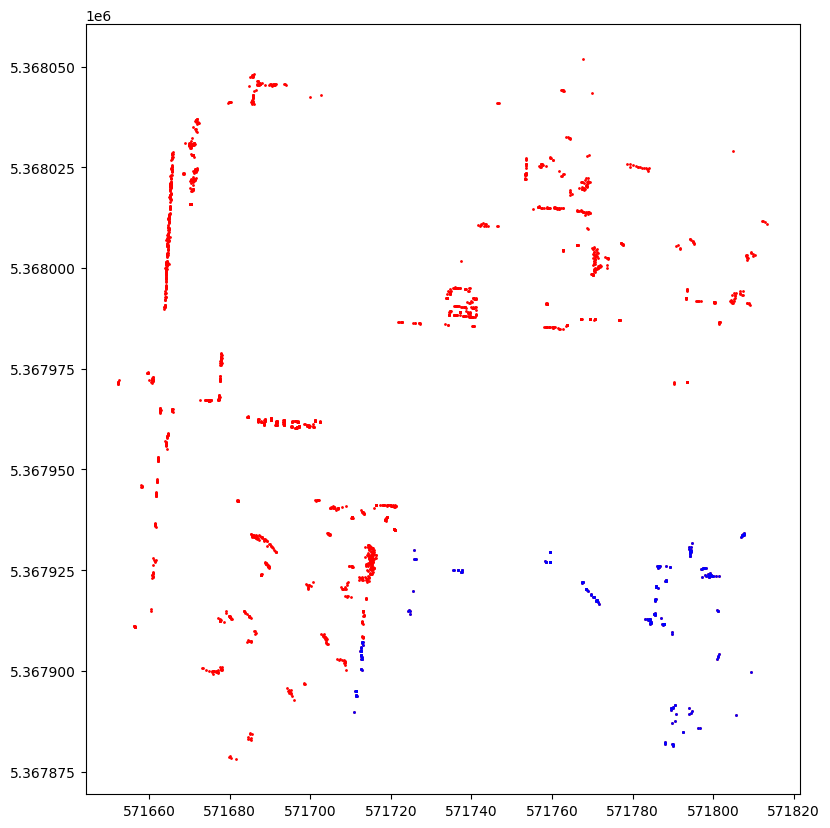

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 96.0469970703125


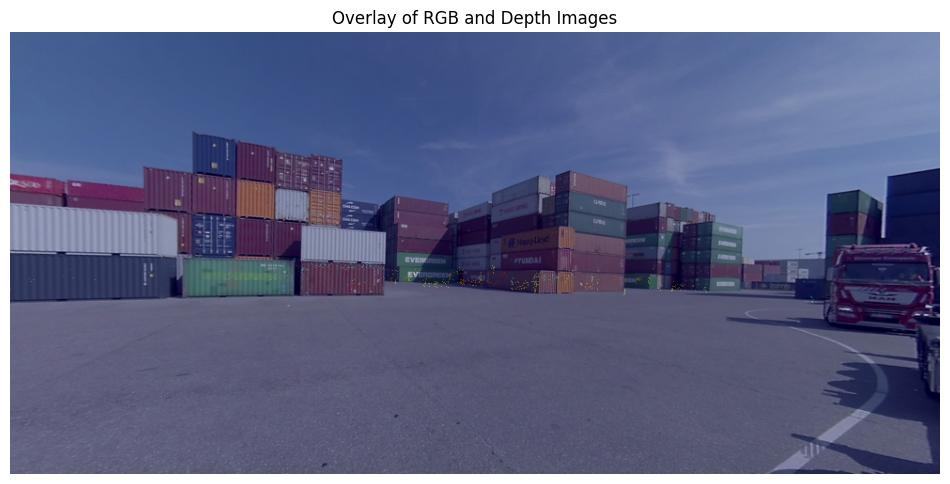

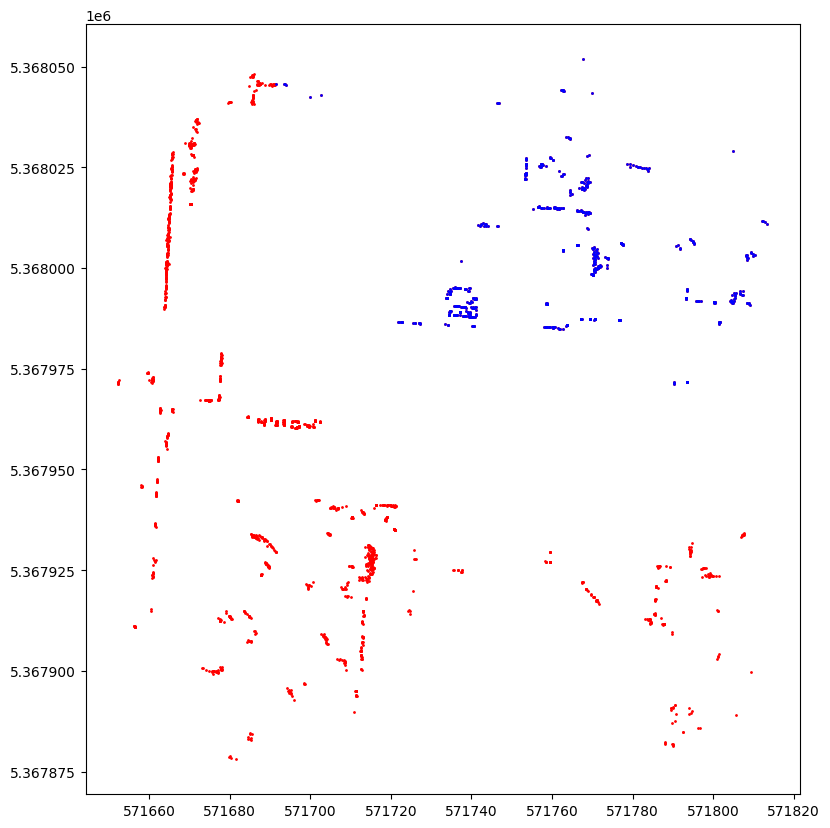

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 81.56742095947266


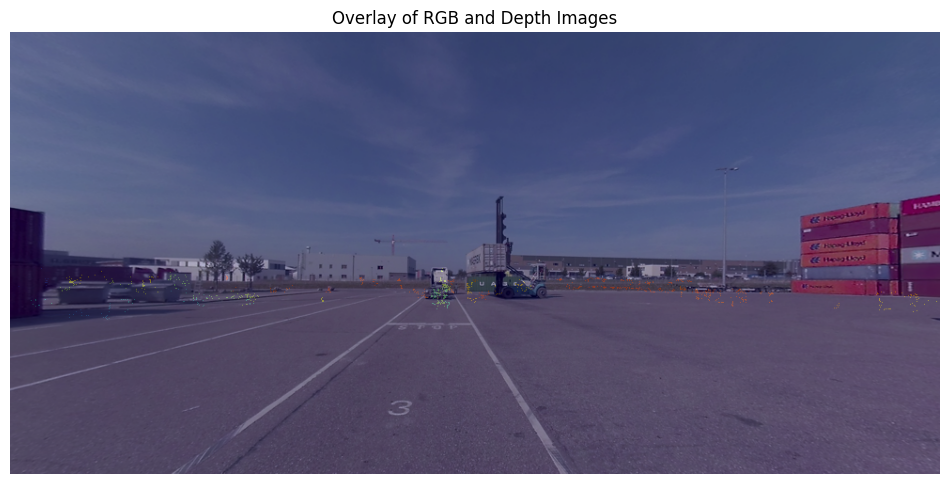

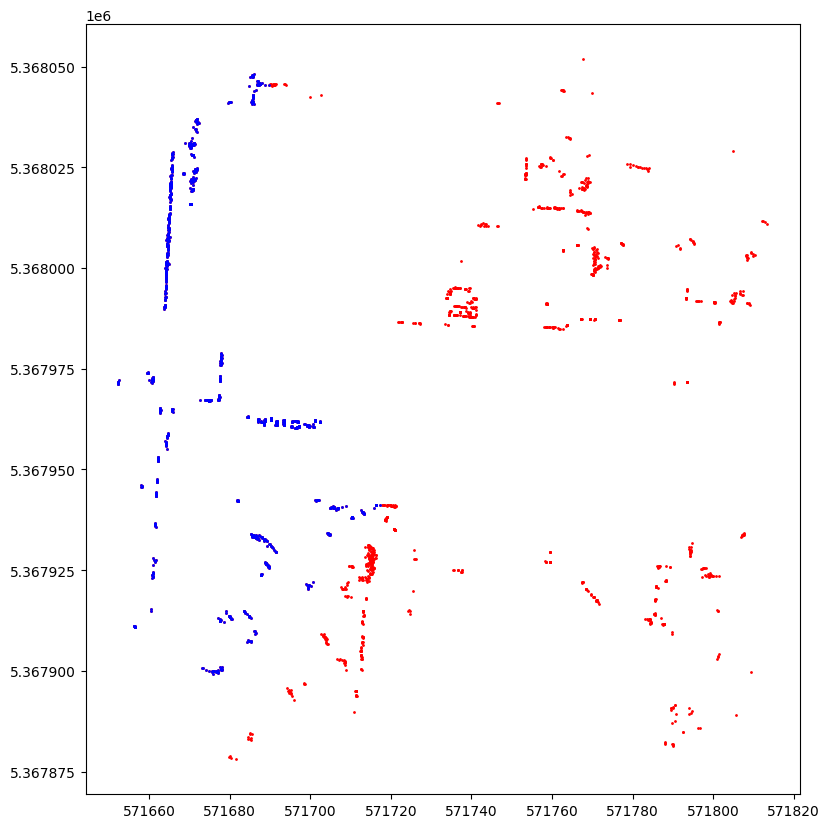

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 82.68350219726562


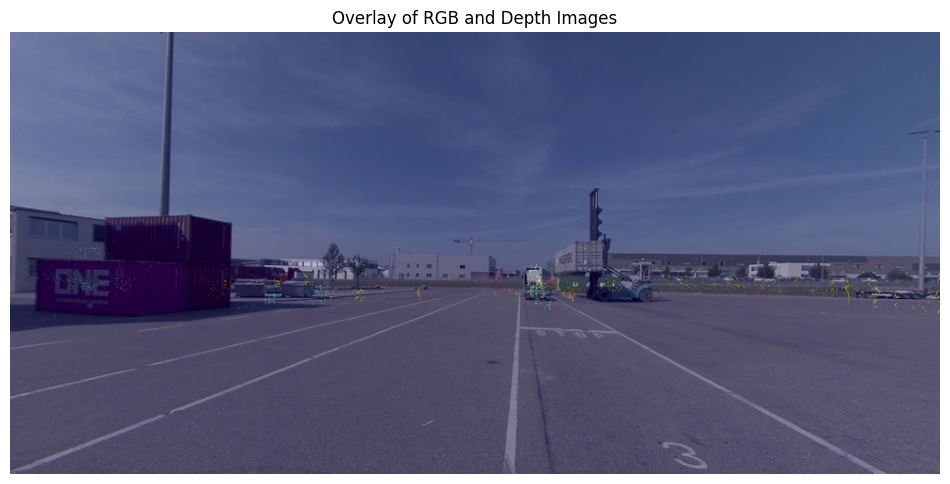

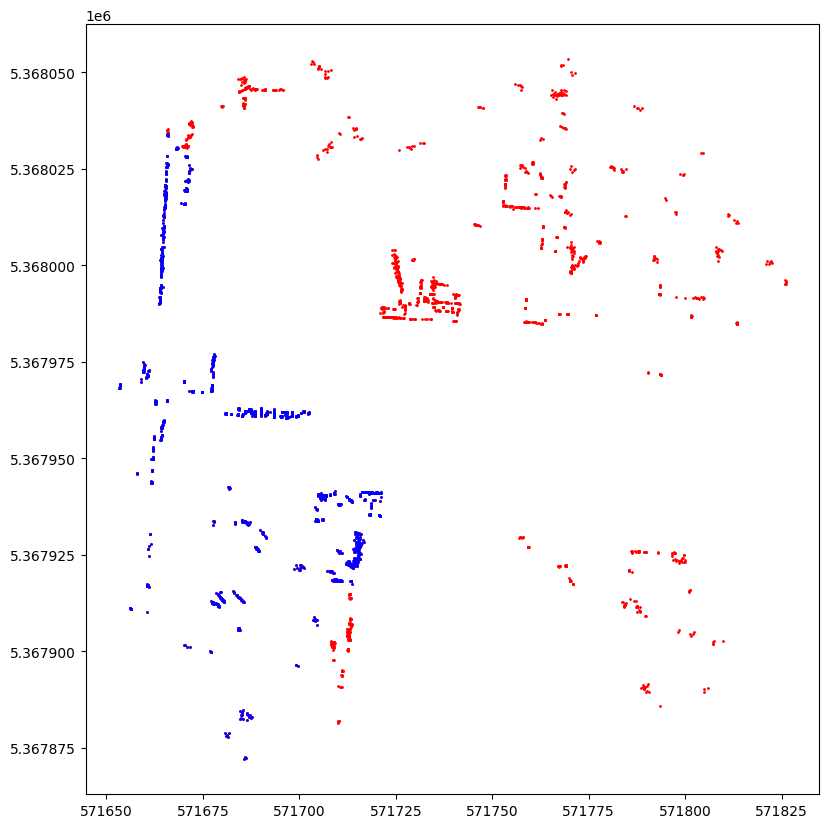

JHIS
HI
Depth image shape: (471, 990)
Depth image dtype: float32
Depth image min: 0.0, max: 97.88821411132812


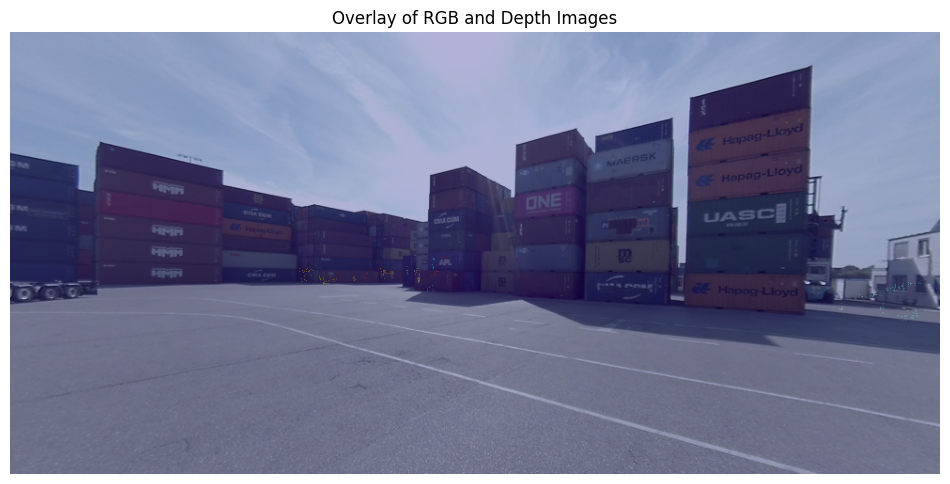

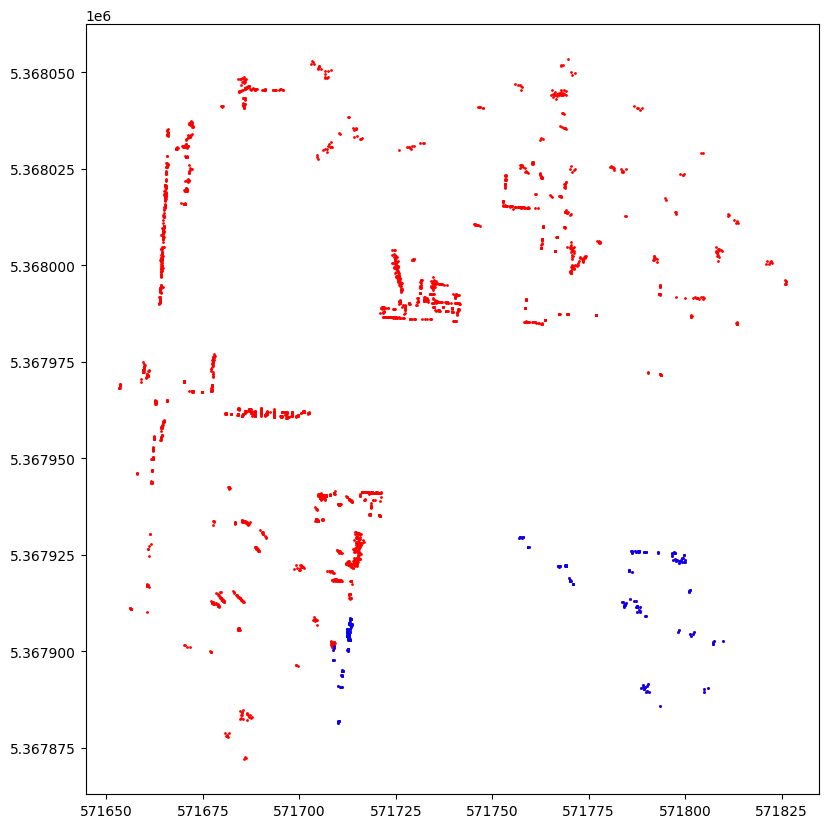

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

start = 55000
end = start + 10

for i in range(start, end):
    # Assuming dataset[0] returns the images and other data correctly
    print("JHIS")
    rgb_image_pil, depth_image_pil, pose, rgb_intrinsics, depth_intrinsics, points_xyz, points_xyz_filtered = dataset[i]
    print("HI")
    # Convert PIL images to NumPy arrays
    rgb_image = np.array(rgb_image_pil)
    depth_image = np.array(depth_image_pil)
    # Check if depth_image is None or not a valid array
    if depth_image is None:
        raise ValueError("Depth image is None. Check the dataset.")

    print(f"Depth image shape: {depth_image.shape}")
    print(f"Depth image dtype: {depth_image.dtype}")
    print(f"Depth image min: {depth_image.min()}, max: {depth_image.max()}")

    # Ensure depth_image is a 2D array
    if len(depth_image.shape) > 2:
        depth_image = depth_image.squeeze()

    # Normalize the depth image to be in the range [0, 255]
    depth_normalized = cv2.normalize(depth_image, None, 0, 255, cv2.NORM_MINMAX)

    # Check if normalization was successful
    if depth_normalized is None:
        raise ValueError("Normalization failed. Check the input depth image.")

    depth_normalized = np.uint8(depth_normalized)

    # Apply the HSV colormap to the depth image
    depth_colormap = cv2.applyColorMap(depth_normalized, cv2.COLORMAP_JET)

    # Convert RGB image to BGR for OpenCV processing
    rgb_image_bgr = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)

    # Overlay the depth colormap on the RGB image
    overlay = cv2.addWeighted(rgb_image_bgr, 0.7, depth_colormap, 0.3, 0)

    # Convert BGR back to RGB for displaying with Matplotlib
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Display the overlay
    plt.figure(figsize=(12, 10))
    plt.imshow(overlay)
    plt.title('Overlay of RGB and Depth Images')
    plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(10, 10))
    plt.scatter(points_xyz[:, 0], points_xyz[:, 1], c="r", s=1)
    plt.scatter(points_xyz_filtered[:, 0], points_xyz_filtered[:, 1], c="b", s=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    if i > start + 10:
        break